Fast R-CNN
==========
Surge como mejora de la R-CNN, anteriormente se ejecutaba el algoritmo de Selective Search (SS) para obtener las regiones de interés (RoI) y analizarlas individualmente en la CNN, esto es sumamente costoso y lento. Fast R-CNN utiliza una CNN para extraer características de la imagen completa (evitando así realizar tantas convoluciones sobre las RoIs), se usa SS para obtener las RoIs y se pasan a dos capas totalmente conectadas para obtener las predicciones de las clases y las coordenadas de los bounding boxes. 

Durante este proceso existe una capa intermedia conocida como RoI Pooling, donde a cada RoI generada, se toma una sección del mapa de características correspondiente y se reduce a un tamaño fijo (como lo hace MaxPooling). Esto permite que la CNN pueda aprender características de las RoIs y que estas características sean invariantes a la posición de la RoI en la imagen.

En la imagen creada por el autor del artículo se puede ver el proceso de Fast R-CNN:

<center>

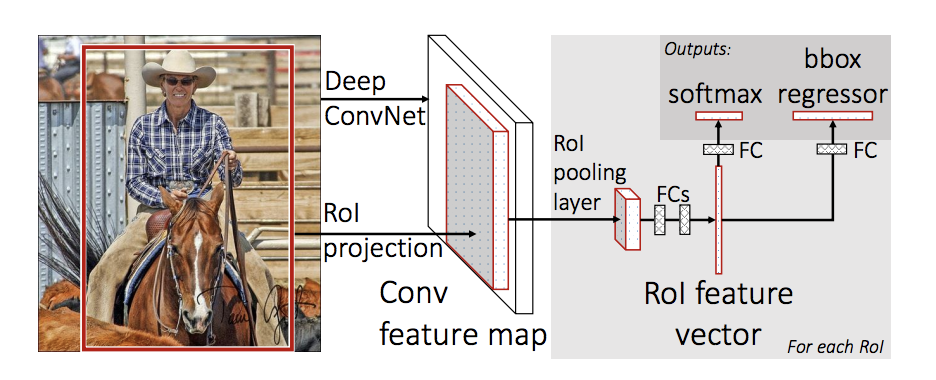

</center>

Implementación
==============

In [ ]:
# Selective Search
import cv2
import os
import numpy as np
from scipy.ndimage import find_objects
from skimage.segmentation import find_boundaries
from skimage.feature import local_binary_pattern
from skimage.segmentation import felzenszwalb

# Generamos una imagen que busque el espectro de texturas
def generate_lbp_image(img):
                       
    if len(img.shape) == 2: 
        img = img.reshape(img.shape[0], img.shape[1], 1)

    channels = img.shape[2]
    lbp_img = np.zeros(img.shape)

    for c in range(channels):
        layer = img[:, :, c]
        lbp_img[:, :, c] = local_binary_pattern(layer, 8, 1, method="uniform")

    return lbp_img

# Formulas de similitud
def color_sim(ri, rj):
    return sum([min(a, b) for a, b in zip(ri["color_hist"], rj["color_hist"])])

def texture_sim(ri, rj):
    return sum([min(a, b) for a, b in zip(ri["texture_hist"], rj["texture_hist"])])

def size_sim(ri, rj, img_size):
    return 1 - ((ri["size"] + rj["size"]) / img_size)

def fill_sim(ri, rj, img_size):
    bbsize = (max(ri["box"][2], rj["box"][2]) - min(ri["box"][0], rj["box"][0])) * (max(ri["box"][3], rj["box"][3]) - min(ri["box"][1], rj["box"][1]))
    return 1 - ((bbsize - ri["size"] - rj["size"]) / img_size)

# Calculamos el histograma de color

def color_hist(mask, img):

    BINS = 25
    if len(img.shape) == 2: 
        img = img.reshape(img.shape[0], img.shape[1], 1)

    channels = img.shape[2]
    hist = np.array([])

    for c in range(channels):
        layer = img[:, :, c][mask]
        hist = np.concatenate([hist] + [np.histogram(layer, BINS)[0]])

    hist /= np.sum(hist)

    return hist

# Calculamos el histograma de textura
def texture_hist(mask, lbp_img):

    BINS = 10
    channels = lbp_img.shape[2]
    hist = np.array([])

    for c in range(channels):
        layer = lbp_img[:, :, c][mask]
        hist = np.concatenate([hist] + [np.histogram(layer, BINS)[0]])

    hist /= np.sum(hist)

    return hist

# Calculamos la similitud entre dos regiones
def sim(ri, rj, img_size):
    return color_sim(ri, rj) + texture_sim(ri, rj) + size_sim(ri, rj, img_size) + fill_sim(ri, rj, img_size)

# Clase que agrupa las regiones
class HGrouping:

    def __init__(self, img, img_seg):
        self.img = img
        self.img_seg = img_seg.copy()
        self.labels = np.unique(img_seg).tolist()

    # Construimos las regiones
    def build_regions(self):

        self.regions = {}
        lbp_img = generate_lbp_image(self.img)

        # Para cada etiqueta 
        for label in self.labels:

            # Generamos la region
            size = np.sum(self.img_seg == label)
            region_slice = find_objects(self.img_seg == label)[0]
            box = (region_slice[1].start, region_slice[0].start, region_slice[1].stop, region_slice[0].stop)
            mask = self.img_seg == label

            chist = color_hist(mask, self.img)
            thist = texture_hist(mask, lbp_img)

            self.regions[label] = {"size": size, "box": box, "color_hist": chist, "texture_hist": thist}

    # Buscamos los vecinos de una region
    def find_neighbors(self, label):
        boundary = find_boundaries(self.img_seg == label, mode="outer")
        neighbors = np.unique(self.img_seg[boundary]).tolist()
        return neighbors

    # Construimos los pares de regiones
    def build_regions_pairs(self):        
        self.region_pairs = {}
        for i in self.labels:
            neighbors = self.find_neighbors(self.labels[i])
            for j in neighbors:
                if i < j:
                    self.region_pairs[(i, j)] = sim(self.regions[i], self.regions[j], self.img.size)

    # Obtenemos el par de regiones con mayor similitud
    def get_highest_similarity(self):
        return sorted(self.region_pairs.items(), key=lambda x: x[1], reverse=True)[-1][0]
    
    # Unimos dos regiones
    def merge_regions(self, i, j):

        new_label = max(self.labels) + 1
        self.labels.append(new_label)

        # Calculamos los nuevos valores de la region
        ri, rj = self.regions[i], self.regions[j]
        new_size = ri["size"] + rj["size"]
        new_box = (
            min(ri["box"][0], rj["box"][0]), 
            min(ri["box"][1], rj["box"][1]), 
            max(ri["box"][2], rj["box"][2]), 
            max(ri["box"][3], rj["box"][3])
        )

        value = {
            "box": new_box,
            "size": new_size,
            "color_hist": (ri["color_hist"] * ri["size"] + rj["color_hist"] * rj["size"]) / new_size,
            "texture_hist": (ri["texture_hist"] * ri["size"] + rj["texture_hist"] * rj["size"]) / new_size
        }

        # Creamos una etiqueta nueva
        self.regions[new_label] = value
        
        # Actualizamos las regiones
        self.img_seg[self.img_seg == i] = new_label
        self.img_seg[self.img_seg == j] = new_label

    # Eliminamos las regiones que se han unido
    def remove_similarities(self, i, j):

        key_to_delete = []
        for key in self.region_pairs.keys():
            if i in key or j in key:
                key_to_delete.append(key)

        for key in key_to_delete:
            del self.region_pairs[key]

        self.labels.remove(i)
        self.labels.remove(j)

    # Calculamos la similitud de las nuevas regiones 
    def calculate_similarity_for_new_regions(self):

        i = max(self.labels)
        neighbors = self.find_neighbors(i)

        for j in neighbors:
            self.region_pairs[(i, j)] = sim(self.regions[i], self.regions[j], self.img.size)

    # Comprobamos si quedan regiones por unir
    def is_empty(self):
        return True if len(self.region_pairs) == 0 else False
    
# Aplicamos el algoritmo
def selective_search(img, k):

    # Generamos las regiones
    img_seg = felzenszwalb(img, scale = k, sigma = 0.5, min_size = 100)
    S = HGrouping(img, img_seg)
    S.build_regions()
    S.build_regions_pairs()

    # Unimos las regiones
    while not S.is_empty():
        i, j = S.get_highest_similarity()
        S.merge_regions(i, j)
        S.remove_similarities(i, j)
        S.calculate_similarity_for_new_regions()

    # Obtenemos todas las bounding boxes
    boxes = [x["box"] for x in S.regions.values()][::-1]
    boxes = list(dict.fromkeys(boxes))

    priorities = list(range(1, len(boxes) + 1))
    return boxes, priorities

# Intersection over Union
def iou(ri, rj):

    if ri[0] >= ri[2] or ri[1] >= ri[3] or rj[0] >= rj[2] or rj[1] >= rj[3]:
        return 0
    
    x = max(ri[0], rj[0])
    y = max(ri[1], rj[1])
    w = min(ri[2], rj[2]) - x
    h = min(ri[3], rj[3]) - y

    area_ri = (ri[2] - ri[0]) * (ri[3] - ri[1])
    area_rj = (rj[2] - rj[0]) * (rj[3] - rj[1])

    if w < 0 or h < 0:
        return 0

    area_i = w * h
    area_u = area_ri + area_rj - area_i

    return area_i / (area_u + 1e-6)

# Non-Maximum Suppression
def nms(boxes, priorities, threshold):
    
    boxes = np.array(boxes)
    priorities = np.array(priorities)

    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = priorities.argsort()[::-1]

    keep = []

    while order.size > 0:

        i = order[0]
        keep.append(i)

        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= threshold)[0]
        order = order[inds + 1]

    return boxes[keep]

# Obtenemos la información de la imagen
def get_img_info(img_path, label_path, img_size = 64):

    # Leemos la imagen y la redimensionamos
    img = cv2.imread(img_path)
    img = cv2.resize(img, (img_size, img_size))

    # Generamos las RoIs
    boxes, priorities = selective_search(img, 100)
    boxes = nms(boxes, priorities, 0.3)

    # Cargamos las BB correctas y sus etiquetas
    with open(label_path, "r") as f:
        label = f.read()
        label = label.split("\n")
        data = label.split(" ")
        box = [int(data[1]), int(data[2]), int(data[3]), int(data[4])]
        label = int(data[0])

    return (img, boxes), (box, label)

# Cargamos los datasets
# TODO: Etiquetar dataset
def generate_rois(train_imgs_path, train_labels_path, test_imgs_path, test_labels_path):

    train_x = []
    train_y = []
    test_x = []
    test_y = []

    train_imgs = os.listdir(train_imgs_path)
    train_labels = os.listdir(train_labels_path)
    test_imgs = os.listdir(test_imgs_path)
    test_labels = os.listdir(test_labels_path)

    assert len(train_imgs) == len(train_labels)
    assert len(test_imgs) == len(test_labels)

    for i in range(len(train_imgs)):
        img_path = os.path.join(train_imgs_path, train_imgs[i])
        label_path = os.path.join(train_labels_path, train_labels[i])
        img, label = get_img_info(img_path, label_path)
        train_x.append(img)
        train_y.append(label)

    for i in range(len(test_imgs)):
        img_path = os.path.join(test_imgs_path, test_imgs[i])
        label_path = os.path.join(test_labels_path, test_labels[i])
        img, label = get_img_info(img_path, label_path)
        test_x.append(img)
        test_y.append(label)

    return np.array(train_x), np.array(train_y), np.array(test_x), np.array(test_y)

train_x, train_y, test_x, test_y = generate_rois("train", "train_labels", "test", "test_labels")

In [ ]:
# Activamos el uso de la GPU
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [ ]:
import tensorflow as tf
import keras.backend as K
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Layer, Dropout, Input, TimeDistributed
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy

# Creamos una capa para el RoI Pooling
class ROIPooling(Layer):
    
    def __init__(self, pool_size, num_rois, **kwargs):

        self.dim_ordering = K.image_data_format()
        self.pool_size = pool_size
        self.num_rois = num_rois

        super(ROIPooling, self).__init__(**kwargs)

    def build(self, input_shape):
        self.nb_channels = input_shape[0][3]   

    def compute_output_shape(self, input_shape):
        return None, self.num_rois, self.pool_size, self.pool_size, self.nb_channels

    # Vamos a pasarle a la función el mapa de características y las RoIs
    def call(self, x, mask = None):

        assert(len(x) == 2)

        img = x[0]
        rois = x[1]

        input_shape = K.shape(img)
        outputs = []

        # Recorremos las RoIs
        for roi_idx in range(self.num_rois):

            x = rois[0, roi_idx, 0]
            y = rois[0, roi_idx, 1]
            w = rois[0, roi_idx, 2]
            h = rois[0, roi_idx, 3]

            x = K.cast(x, 'int32')
            y = K.cast(y, 'int32')
            w = K.cast(w, 'int32')
            h = K.cast(h, 'int32')

            # Recortamos el mapa de características con el RoI y le aplicamos Max Pooling
            rs = tf.image.resize(img[:, y : y + h, x : x + w, :], (self.pool_size, self.pool_size))
            outputs.append(rs)

        # Concatenamos los resultados
        final_output = K.concatenate(outputs, axis = 0)
        final_output = K.reshape(final_output, (1, self.num_rois, self.pool_size, self.pool_size, self.nb_channels))
        final_output = K.permute_dimensions(final_output, (0, 1, 2, 3, 4))

        return final_output
    
    def get_config(self):
        config = { 'pool_size': self.pool_size, 'num_rois': self.num_rois }
        base_config = super(ROIPooling, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

# Creamos la red VGG16 para extraer los mapas de características
def vgg16(img):

    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)

    return x

# Creamos la red Fast R-CNN
def fast_rcnn(img, rois, nb_classes = 2):
    
    # Extraemos los mapas de características
    x = vgg16(img)

    # Aplicamos el RoI Pooling
    x = ROIPooling(7, 4)([x, rois])

    # Creamos las 2 capas FC
    x = TimeDistributed(Flatten(name='flatten'))(x)
    x = TimeDistributed(Dense(4096, activation='relu', name='fc1'))(x)
    x = TimeDistributed(Dropout(0.5))(x)
    x = TimeDistributed(Dense(4096, activation='relu', name='fc2'))(x)
    x = TimeDistributed(Dropout(0.5))(x)
    
    # Creamos dos capas de salida, una para la clasificación y otra para la regresión de la bounding box
    out_class = TimeDistributed(Dense(nb_classes, activation='softmax', kernel_initializer='zero'), name='dense_class_{}'.format(nb_classes))(x)
    out_regr = TimeDistributed(Dense(4 * (nb_classes - 1), activation='linear', kernel_initializer='zero'), name='dense_regress_{}'.format(nb_classes))(x)

    return [out_class, out_regr]

# Creamos la función de pérdida para el clasificador -log(p)
def loss_classifier(t_class, p_class):        
    return K.mean(categorical_crossentropy(t_class, p_class))

# Creamos la función de pérdida para la regresión 0.5x^2 si |x| < 1, |x| - 0.5 si |x| >= 1
def loss_regressor(t_regr, p_regr):
    return tf.losses.huber_loss(t_regr, p_regr)

# Creamos la función de pérdida total será la suma de ambas funciones de pérdida
def loss(p_class, t_class, p_regr, t_regr):
    loss_class = loss_classifier(t_class, p_class)
    loss_regr = loss_regressor(t_regr, p_regr)
    return loss_class + loss_regr

# Definimos las entradas de la red
img_input = Input(shape=(None, None, 3))
roi_input = Input(shape=(None, 4))

# Creamos el modelo
classifier = Model([img_input, roi_input], fast_rcnn(img_input, roi_input))
classifier.summary()

# Hiperparámetros
batch_size = 4
epochs = 10
optimizer = Adam(lr=1e-5)

# Transformamos los datos a tensores
train_set = tf.data.Dataset.from_tensor_slices((train_x, train_y)).batch(batch_size)
valid_set = tf.data.Dataset.from_tensor_slices((test_x, test_y)).batch(batch_size)

# Ejecutamos el entrenamiento
for epoch in range(epochs):
    
    print('Epoch {}/{}'.format(epoch + 1, epochs))

    for step, (x, y) in enumerate(train_set):
        
        with tf.GradientTape() as tape:
            pred = classifier([x, y[0]])
            loss_value = loss(pred[0], y[1], pred[1], y[2])
            
        grads = tape.gradient(loss_value, classifier.trainable_weights)
        optimizer.apply_gradients(zip(grads, classifier.trainable_weights))
        
        print('Step {}: Loss = {}'.format(step, loss_value.numpy()))